In [22]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [12]:
neural = sc.read_h5ad('../SVM23/data/neural_data_0606.h5ad')

state_path = '../SVM23/models/neural_vf_0606_model.pt'

vt.md.Velvet.setup_anndata(neural, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    neural,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

trained_state = torch.load(state_path)['model_state_dict']

model.module.load_state_dict(trained_state)

INFO     Generating sequential column names                                                  


<All keys matched successfully>

In [14]:
model.module = model.module.to("cuda")
copy = model.adata.copy()
copy.layers['velocity'] = model.predict_velocity()

In [38]:
copy.obs['plotto'] = [c if c in ['Neural','pMN'] else 'other' for c in copy.obs.cell_annotation]

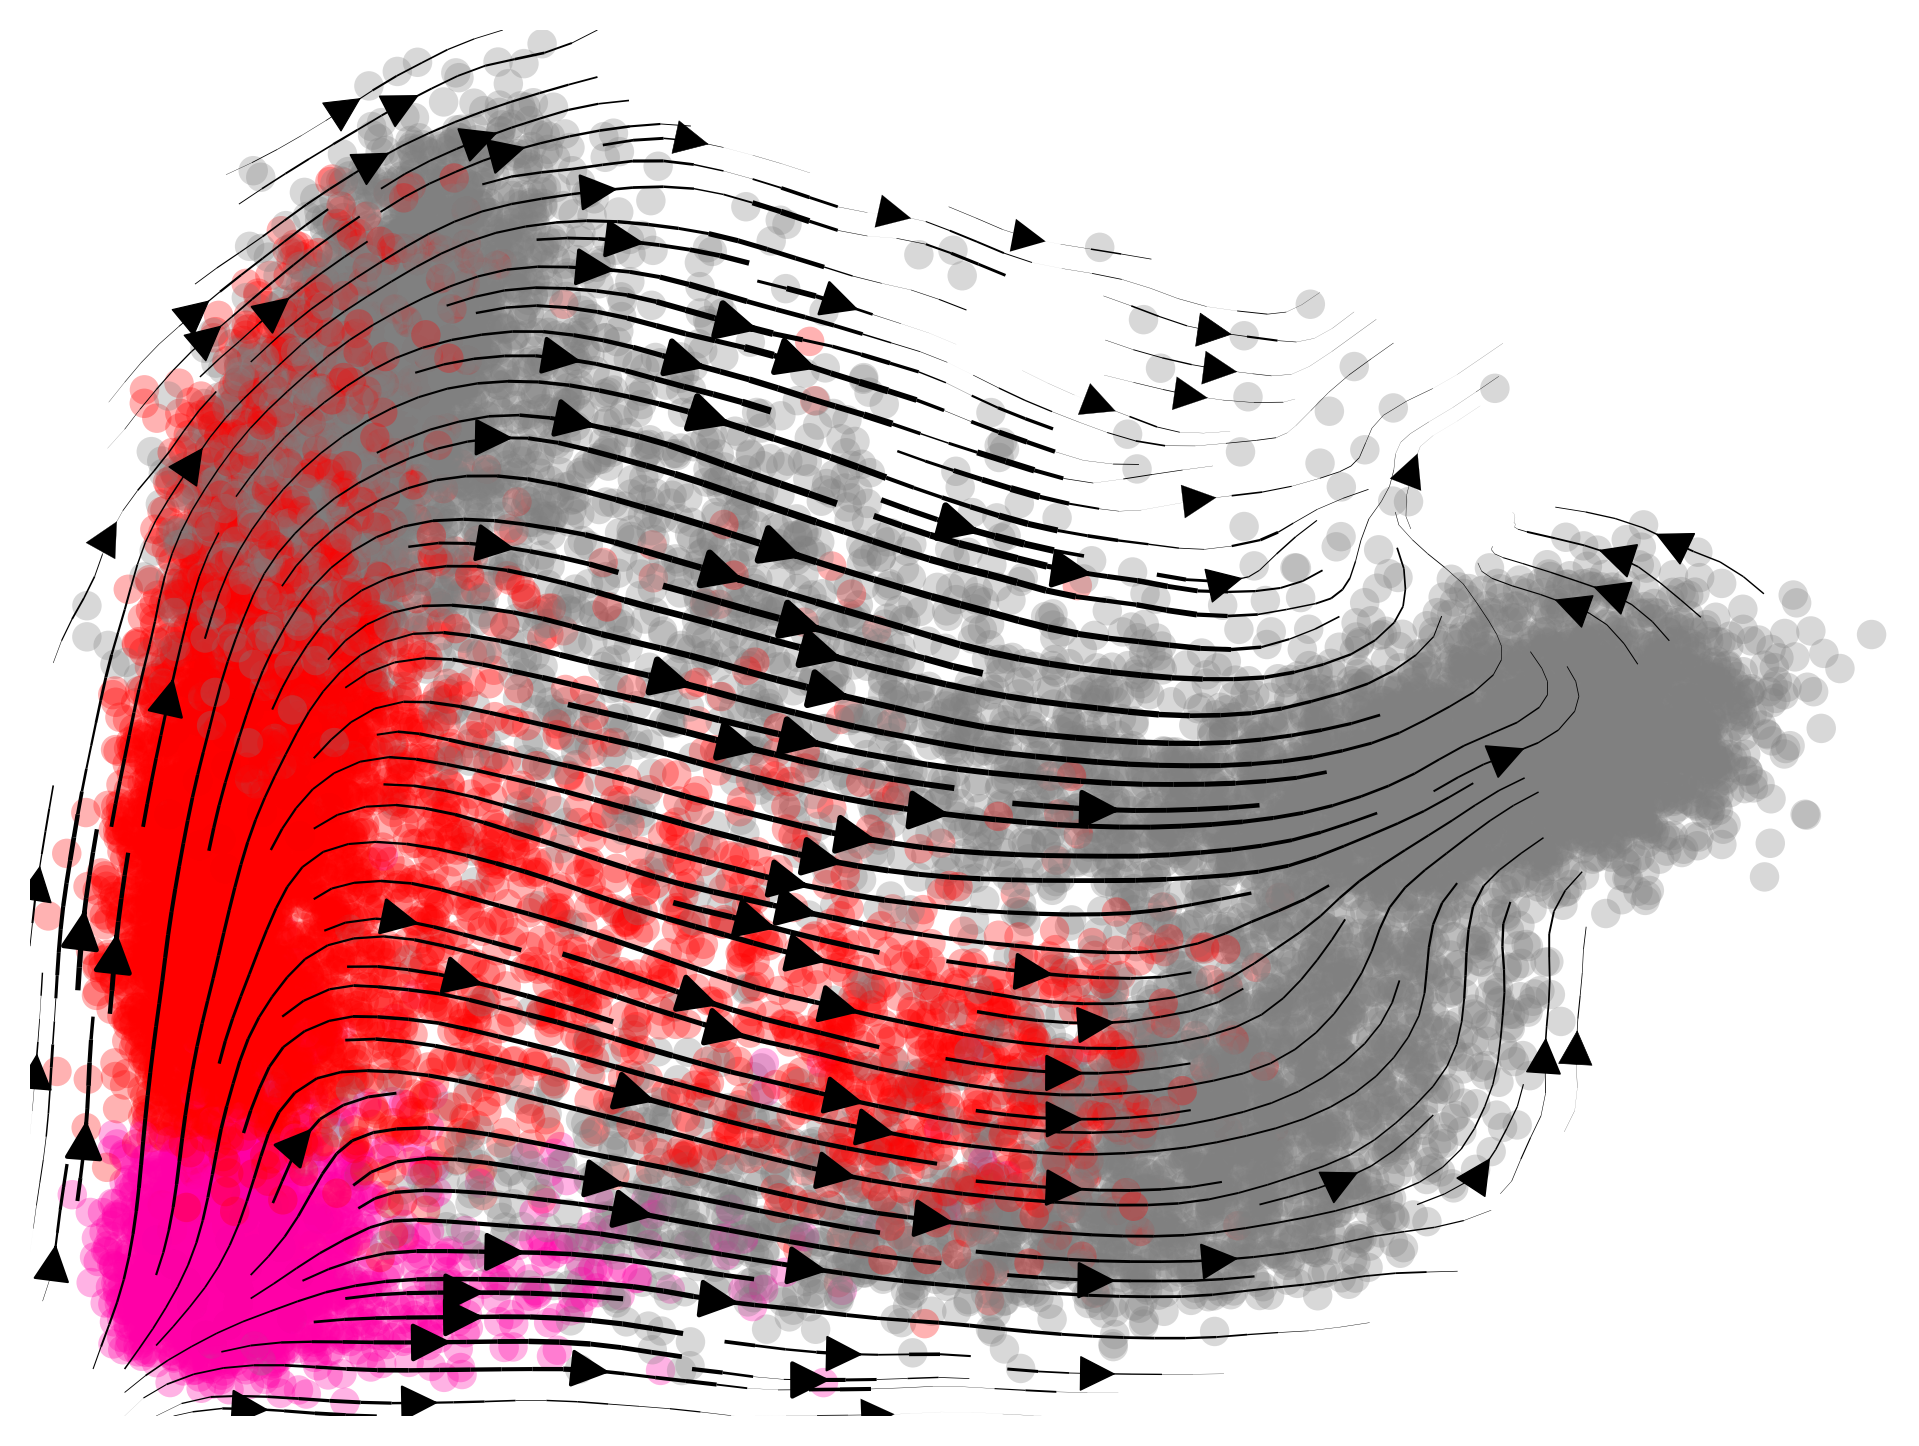

In [39]:
scaler = StandardScaler(with_mean=True, with_std=False)
pca = PCA()

X = copy.layers['total']
V = copy.layers['velocity']
X = np.array(X.A if issparse(X) else X)
V = np.array(V.A if issparse(V) else V)
Y = np.clip(X + V, 0, 1000)
            
Xlogscale = scaler.fit_transform(np.log1p(X))      
Ylogscale = scaler.transform(np.log1p(Y))
Xpca = pca.fit_transform(Xlogscale)
Ypca = pca.transform(Ylogscale)

copy.obsm['X_pca'] = Xpca
copy.varm['PCs'] = pca.components_
copy.obsm['velocity_pca'] = Ypca - Xpca
copy.uns["velocity_params"] = {'embeddings':'pca'}

fig = plt.figure(figsize=(8,6), dpi=300)

ax = fig.subplots()

scv.pl.velocity_embedding_stream(
    copy, 
    basis='pca', 
    title="",
    color='plotto', 
    show=False,
    ax=ax,
    palette={'Neural':'#ff00a7','pMN':'#ff0000','other':'grey'},
    arrow_size=2,
    legend_fontoutline=10,
    size=200,
    fontsize=16,
    legend_loc=False,
    legend_fontsize=16, components='1,2'
)
plt.savefig("11_genescore1.png", transparent=True, bbox_inches='tight')
plt.show()


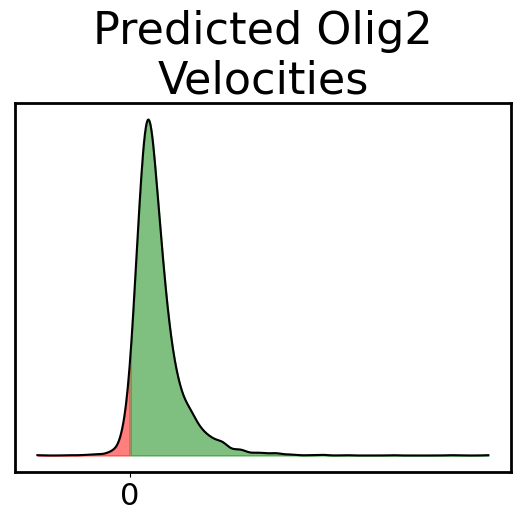

In [58]:
x = np.array(copy[copy.obs.cell_annotation=='Neural','Olig2'].layers['velocity'].flatten())

kde = gaussian_kde(x)
x_range = np.linspace(min(x), max(x), 500)
kde_values = kde(x_range)

plt.plot(x_range, kde_values, color='black')  # KDE curve
plt.fill_between(x_range, kde_values, where=(x_range < 0), color='red', alpha=0.5)
plt.fill_between(x_range, kde_values, where=(x_range >= 0), color='green', alpha=0.5)

plt.xticks([0], fontsize=22)
plt.yticks([])


current_axes = plt.gca()
for spine in current_axes.spines.values():
    spine.set_linewidth(2)

plt.title("Predicted Olig2\nVelocities", fontsize=32)
plt.savefig("11_genescore2.png", transparent=True, bbox_inches='tight')
plt.show()


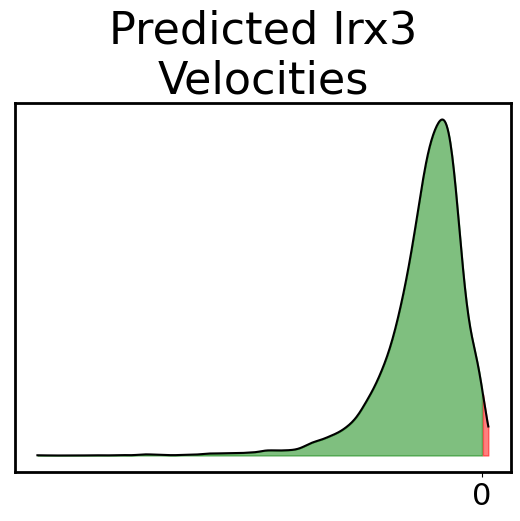

In [60]:
x = np.array(copy[copy.obs.cell_annotation=='pMN','Irx3'].layers['velocity'].flatten())
kde = gaussian_kde(x)
x_range = np.linspace(min(x), max(x), 500)
kde_values = kde(x_range)

plt.plot(x_range, kde_values, color='black')  # KDE curve
plt.fill_between(x_range, kde_values, where=(x_range < 0), color='green', alpha=0.5)
plt.fill_between(x_range, kde_values, where=(x_range >= 0), color='red', alpha=0.5)

plt.xticks([0], fontsize=22)
plt.yticks([])


current_axes = plt.gca()
for spine in current_axes.spines.values():
    spine.set_linewidth(2)

plt.title("Predicted Irx3\nVelocities", fontsize=32)
plt.savefig("11_genescore3.png", transparent=True, bbox_inches='tight')
plt.show()
